In [20]:
import os

import copy
import math
import itertools as it
import importlib

import pandas as pd
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.widgets as widgets

from numba import jit

from pyproj import Proj
import cv2

import boat_shape
from boat_shape import OUTLINE as BOAT_OUTLINE

import process as p
import analysis as a
import chart as c
import global_variables as G
from utils import DictClass


In [8]:
cd /Users/billey/scode/slogs

/Users/billey/Sailing/Sailboat/SailData/CanboatLogs/logs


In [99]:

SAMPLES_PER_SECOND = 10

# Tacks take 20 seconds or more
# Compute the approximately constant TWD through the tack
# Compute the VMG through the tack (using TWD)
# Find the beginning of the tack (rudder??)
# Measure the lost boat lengths.
# Measure the time before returning to full speed
# Measure the initial "tack angle" and final "tack angle"
def find_tacks(df, buffer=20):
    if False:
        skip = 1
        dt = skip / SAMPLES_PER_SECOND
        sdf = rdf.copy()
    else:
        # a tack is a transition from close hauled port to stbd (and vice versa).
        skip = 5
        dt = skip / SAMPLES_PER_SECOND
        sdf = df[::skip].copy()

    # remove noise
    # sdf['hdg_f'] = scipy.ndimage.median_filter(uhdg, int(10 / dt), origin=0)
    # sdf['awa_f'] = scipy.ndimage.median_filter(np.array(sdf.awa), int(10 / dt), origin=0)

    sdf['hdg_f'], _ = p.exponential_filter_angle(np.array(sdf.hdg), 0.995, 4)
    sdf['awa_f'], _ = p.exponential_filter_angle(np.array(sdf.awa), 0.995, 4)

    # find regions where boat is always close hauled for a period of time
    period = int(5 / dt)
    sdf['is_stbd_hauled_raw'] = scipy.ndimage.minimum_filter1d((sdf.awa_f > 15) & (sdf.awa_f < 45), period)
    sdf['is_port_hauled_raw'] = scipy.ndimage.minimum_filter1d((sdf.awa_f < -15) & (sdf.awa_f > -45), period)

    # expand so that we can find overlaps, i.e. tacks
    sdf['is_stbd_hauled'] = scipy.ndimage.maximum_filter1d(sdf.is_stbd_hauled_raw, 4 * period)
    sdf['is_port_hauled'] = scipy.ndimage.maximum_filter1d(sdf.is_port_hauled_raw, 4 * period)

    # if you are in the overlap between expanded stbd and port hauled then you are
    # tacking!
    sdf['is_tack'] = (sdf.is_stbd_hauled & sdf.is_port_hauled)

    if False:
        c.quick_plot(sdf.index, (sdf.awa, sdf.awa_f, 100*sdf.is_tack, 100*sdf.is_stbd_hauled, 100*sdf.is_port_hauled),
                     "(sdf.hdg, sdf.hdg_f, sdf.awa, sdf.awa_f)".split(),
                     fignum=1)

        c.quick_plot(sdf.index, (sdf.hdg, sdf.hdg_f, sdf.awa, sdf.awa_f, 100*sdf.is_tack),
                     "(sdf.hdg, sdf.hdg_f, sdf.awa, sdf.awa_f)".split(),
                     fignum=1)

    res = []
    for s, e in p.find_runs(np.array(sdf.is_tack)):
        s_extend = int(s-(buffer/dt))
        ##SB:e_extend = int(e+(buffer/dt))
        e_extend = int(e+4*(buffer/dt))   ## rescale tack window, finding more with each increment 
        hdg_before = np.median(sdf.hdg_f.iloc[s_extend:s])
        hdg_after = np.median(sdf.hdg_f.iloc[e:e_extend])
        tack_angle = np.abs(p.angle_diff(hdg_before, hdg_after))
        if True or tack_angle < 115 and tack_angle > 65:
            res.append(slice(sdf.index[s_extend], sdf.index[e_extend]))

    return res, sdf

def show_vmg(df, df_slice):

    df_slice = slice(79140, 105810)

    delay = 16
    dt = 1
    ss = slice(df_slice.start, df_slice.stop, dt)
    dss = slice(ss.start+delay, ss.stop+delay, dt)
    
    mdf = df[ss]
    ddf = df[dss]

    slow_coeff = p.butterworth_filter(0.03, 5)

    vmg = mdf.spd * a.cos_d(np.asarray(ddf.twa))
    ptwa = np.asarray(ddf.twa)
    ptwa[ptwa < 0] = - ptwa[ptwa < 0]
    ptwa = p.smooth(slow_coeff, ptwa, causal=False)

    pawa = np.asarray(ddf.awa)
    pawa[pawa < 0] = - pawa[pawa < 0]

    pvmg = polars_spline(ddf.tws, ptwa-10)

    a.quick_plot(mdf.index,
                 (ddf.tws, ptwa/10, pawa/10, mdf.spd, vmg, pvmg),
                 "tws ptwa, pawa, spd, vmg, polar".split(),
                 fignum=6)

    
    vog_n = dt * ddf.sog * a.north_d(ddf.cog)
    vog_e = dt * ddf.sog * a.east_d(ddf.cog)

    tw_n = dt * ddf.tws * a.north_d(ddf.twd)
    tw_e = dt * ddf.tws * a.east_d(ddf.twd)

    hdg = mdf.hdg + 13.2
    btv_n = dt * mdf.spd * a.north_d(hdg)
    btv_e = dt * mdf.spd * a.east_d(hdg)

    cur_n = 10.0 * (np.asarray(vog_n) - np.asarray(btv_n))
    cur_e = 10.0 * (np.asarray(vog_e) - np.asarray(btv_e))

    chart = a.plot_chart(mdf, 3)
    longitudes = np.asarray(mdf.longitude)
    latitudes = np.asarray(mdf.latitude)
    pos = np.vstack(a.MAP(longitudes, latitudes)).T - (chart.west, chart.south)

    color = 'blue'
    hwidth = dt/5
    for (east, north), ve, vn in it.islice(zip(pos, vog_e, vog_n), 0, None, 10):
        chart.ax.arrow(east, north, ve, vn, head_width=hwidth, length_includes_head=True, color=color)

    color = 'green'
    for (east, north), ve, vn in it.islice(zip(pos, tw_e, tw_n), 0, None, 10):
        chart.ax.arrow(east, north, ve, vn, head_width=hwidth, length_includes_head=True, color=color)

    color = 'red'
    for (east, north), ve, vn in it.islice(zip(pos, btv_e, btv_n), 0, None, 10):
        chart.ax.arrow(east, north, ve, vn, head_width=hwidth, length_includes_head=True, color=color)

    color = 'orange'
    for (east, north), ve, vn in it.islice(zip(pos, cur_e, cur_n), 0, None, 10):
        chart.ax.arrow(east, north, ve, vn, head_width=hwidth, length_includes_head=True, color=color)

def show_tacks():
    DATA_DIRECTORY = '/Users/billey/scode/slogs'
    #DATA_DIRECTORY = '/Users/viola/canlogs'
    example = DictClass(log='2019-11-16_10:09.pd', begin=41076, end=111668)
    example = DictClass(log='2019-10-26_09:40.pd', doc='Grand Prix Saturday.', begin=40503, end=87408)
    example = DictClass(log='2019-10-12_09:45.pd', doc='CYC PSSC Day 1', begin=19081, end=233893)
    example = DictClass(log='2019-11-16_10:09.pd', doc='Snowbird #1.', begin=42548, end=111668)
    sail_logs = [example.log]

    dfs, bdf = p.read_sail_logs(sail_logs, discard_columns=False, skip_dock_only=False, trim=True, path=DATA_DIRECTORY, cutoff=0.3)
    df = dfs[0]
    cdf = df.copy()

    chart = c.plot_chart(df, 3)
    c.draw_track(cdf, chart, color='green')
    chart = a.plot_track(cdf, 1, skip=1)
    
    rdf = df.loc[example.begin : example.end]

    chart = c.plot_track(rdf, 1)

    tacks, tdf = find_tacks(rdf)
    chart = c.plot_chart(rdf, 3)
    c.draw_track(rdf, chart, color='red')
    for tack_slice in tacks:
        tdf = rdf.loc[tack_slice]
        lon, lat = np.asarray(tdf.longitude), np.asarray(tdf.latitude)
        c.draw_track(tdf, chart, color='green')

    tdf = rdf.loc[tacks[5]]
    chart = c.plot_chart(rdf, 3)
    c.draw_track(rdf, chart, color='red')
    c.draw_track(tdf, chart, color='green')
    uhdg = np.degrees(np.unwrap(np.radians(tdf.hdg)))
    scale = G.MS_2_KNOTS
    c.quick_plot(tdf.index, (scale*tdf.spd, scale*tdf.aws, tdf.rudder),
                 legend = "(scale*tdf.spd, scale*tdf.aws, tdf.rudder)".split(),
                 fignum=2, clf=True)


    scale = 10 * G.MS_2_KNOTS
    c.quick_plot(tdf.index, (scale*tdf.spd, uhdg, tdf.awa, scale*tdf.aws, tdf.rudder),
                 legend = "(scale*tdf.spd, uhdg, tdf.awa, scale*tdf.aws, tdf.rudder, awa_f)".split(),
                 fignum=2, clf=True)

    vmg = tdf.spd * G.MS_2_KNOTS * p.cos_d(tdf.twa)

    c.quick_plot(tdf.index, (tdf.tws * G.MS_2_KNOTS, tdf.twa/27, tdf.spd * G.MS_2_KNOTS, tdf.awa/27, vmg),
                 legend = "tws, twa/27, spd, awa/27, vmg".split(),
                 fignum=1, clf=True, title='raw data')


    c.quick_plot(tdf.index, (tdf.tws * G.MS_2_KNOTS, tdf.twd/27, tdf.awa/27, tdf.twa/27),
                 legend = "(tdf.tws, tdf.twd/27, tdf.awa/27, tdf.twa/27".split(),
                 fignum=2, clf=True, title='raw data')
    
def quick_plot(index, data, num=None, clf=True, title=None, legend=None, s=slice(None, None, None)):
    fig = plt.figure(num=num)
    if clf:
        plt.clf()
    for d in data:
        plt.plot(index[s], d[s])
    if legend is not None:
        plt.legend(legend, loc='best')
    if title is not None:
        fig.suptitle(title, fontsize=14, fontweight='bold')

    


In [100]:
    DATA_DIRECTORY = '/Users/billey/scode/slogs'
    #DATA_DIRECTORY = '/Users/viola/canlogs'
    example = DictClass(log='2019-11-16_10:09.pd', begin=41076, end=111668)
    example = DictClass(log='2019-10-26_09:40.pd', doc='Grand Prix Saturday.', begin=40503, end=87408)
    example = DictClass(log='2019-10-12_09:45.pd', doc='CYC PSSC Day 1', begin=19081, end=233893)
    example = DictClass(log='2019-11-16_10:09.pd', doc='Snowbird #1.', begin=42548, end=111668)
    sail_logs = [example.log]

    dfs, bdf = p.read_sail_logs(sail_logs, discard_columns=False, skip_dock_only=False, trim=True, path=DATA_DIRECTORY, cutoff=0.3)
    df = dfs[0]
    cdf = df.copy()

    #chart = c.plot_chart(df, 3)
    #c.draw_track(cdf, chart, color='green')
    #chart = a.plot_track(cdf, 1, skip=1)
    
    rdf = df.loc[example.begin : example.end]

    #chart = c.plot_track(rdf, 1)

    tacks, tdf = find_tacks(rdf)

Session from 2019-11-16 18:09:15.020000, 128865 rows, 3.5797222222222222 hours.


In [103]:
good_tacks=[1,5,6,9,11,14]  ## 1,5 got added by extending window to right
tacks

[slice(42873, 44013, None),
 slice(47933, 49068, None),
 slice(50278, 51403, None),
 slice(51208, 52318, None),
 slice(77818, 78953, None),
 slice(88348, 89458, None),
 slice(91398, 92523, None),
 slice(92493, 93608, None),
 slice(94058, 95188, None),
 slice(97998, 99128, None),
 slice(99343, 100478, None),
 slice(100748, 101848, None),
 slice(103558, 104693, None),
 slice(104573, 105703, None),
 slice(106713, 107848, None),
 slice(109508, 110638, None)]

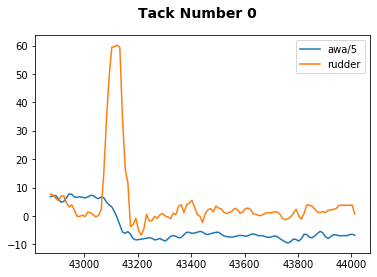

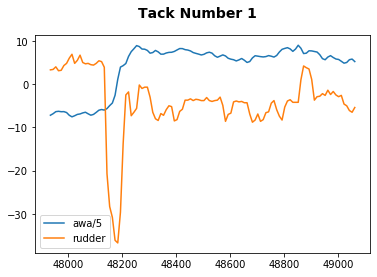

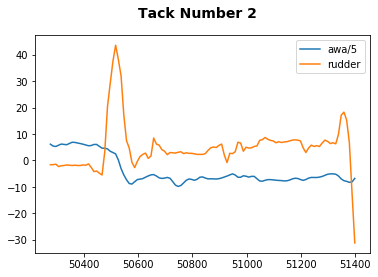

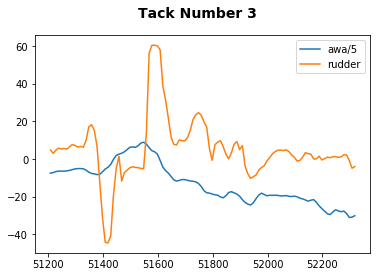

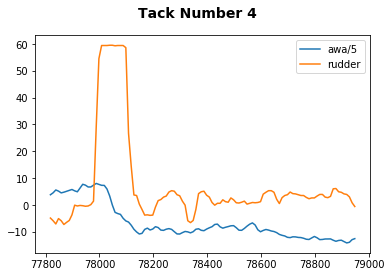

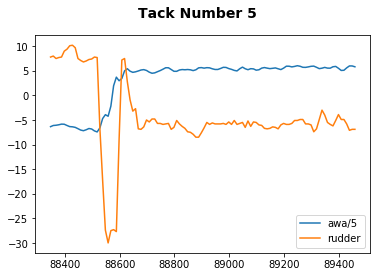

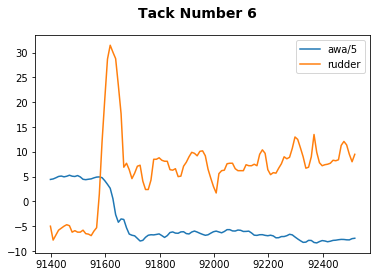

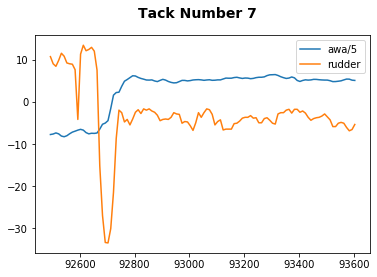

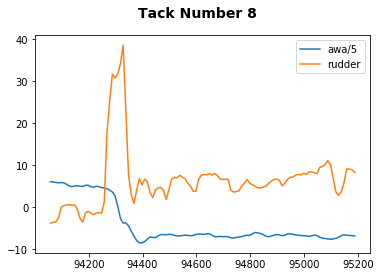

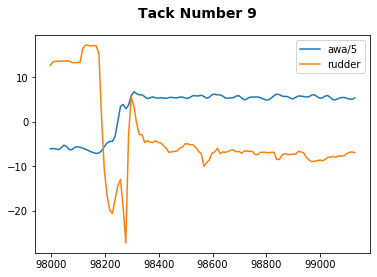

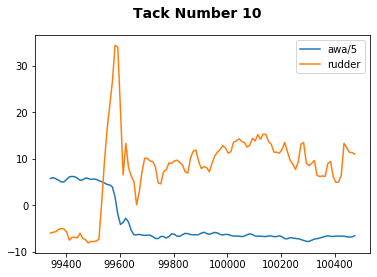

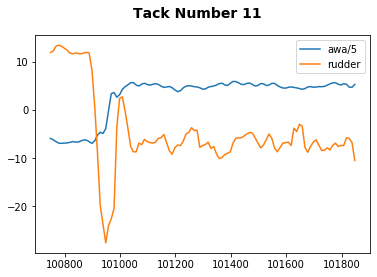

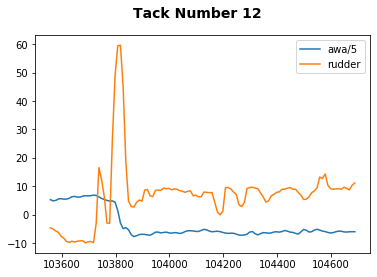

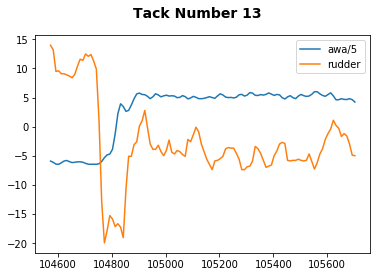

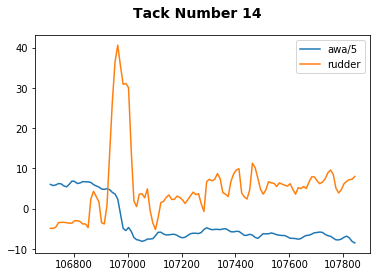

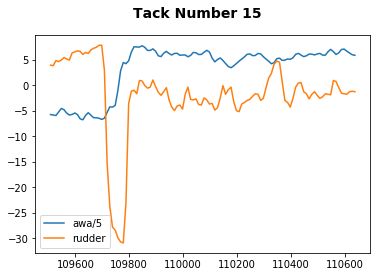

In [109]:
### Let's check the rudder movement looks right on these tacks
for i in range(len(tacks)):
    a_tack=df.loc[tacks[i]]   ## trying the old loc trick!
    quick_plot(a_tack.index, 
               (a_tack.awa/5, a_tack.rudder), 
               legend='awa/5 rudder'.split(),
               title='Tack Number '+str(i), s=slice(None, None, 10))

In [71]:
tacks[0]

slice(42873, 43413, None)

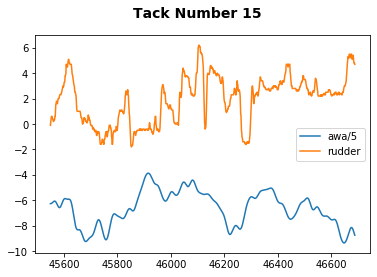

In [110]:
quick_plot(df.index, (df.awa/5, df.rudder), 
            legend='awa/5 rudder'.split(),
            title='Tack Number '+str(i), s=tacks[0])  
## same problem as without the loc trick

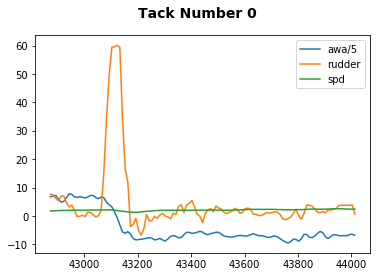

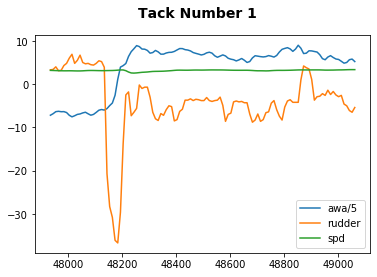

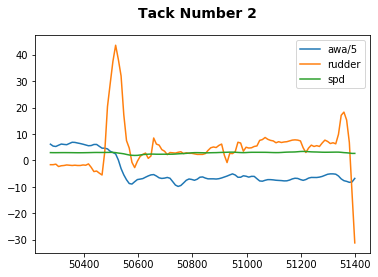

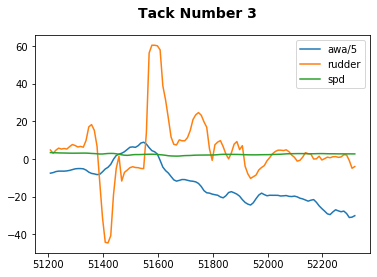

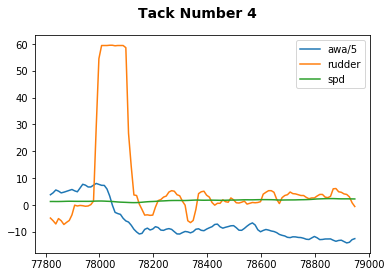

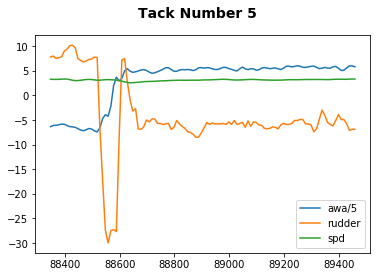

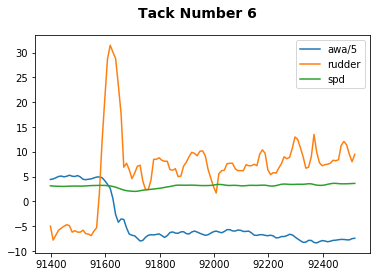

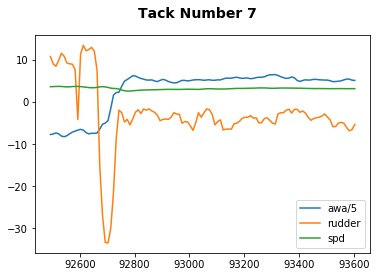

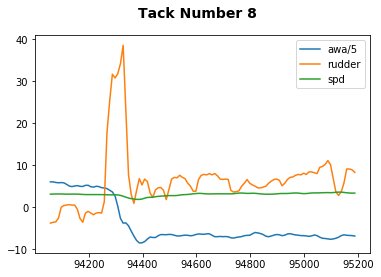

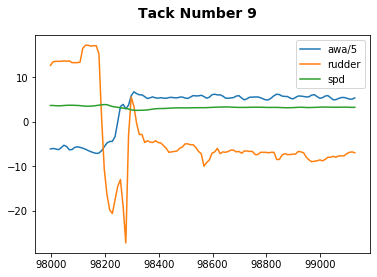

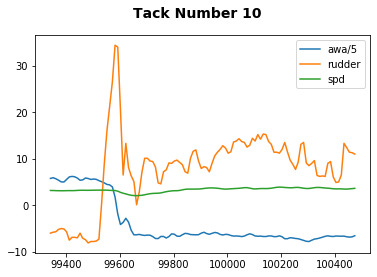

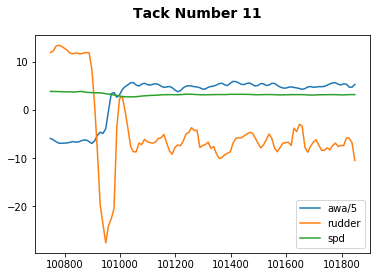

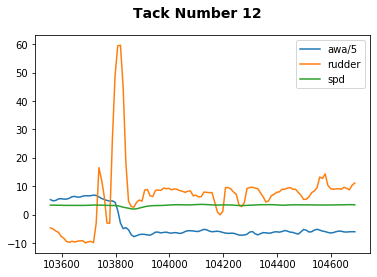

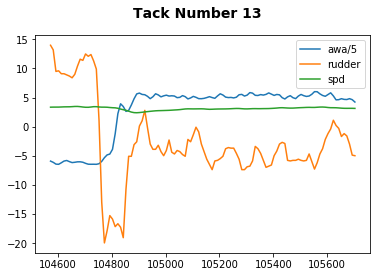

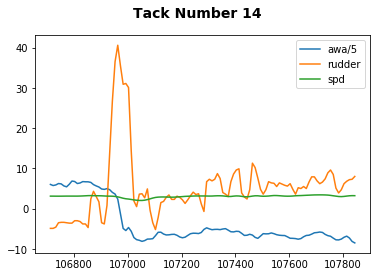

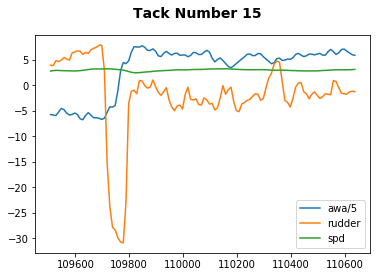

In [112]:
for i in range(len(tacks)):
    a_tack=df.loc[tacks[i]] 
    quick_plot(a_tack.index, 
               (a_tack.awa/5, a_tack.rudder, a_tack.spd), 
               legend='awa/5 rudder spd'.split(),
               title='Tack Number '+str(i), s=slice(None, None, 10))

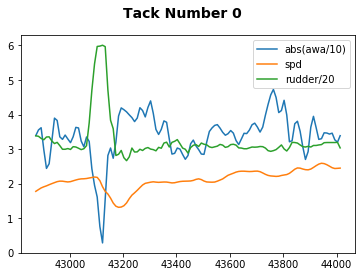

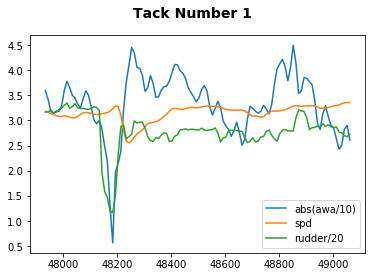

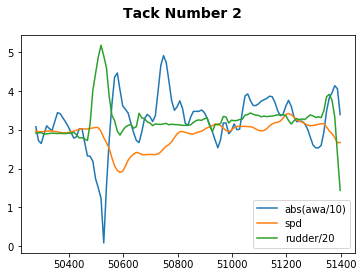

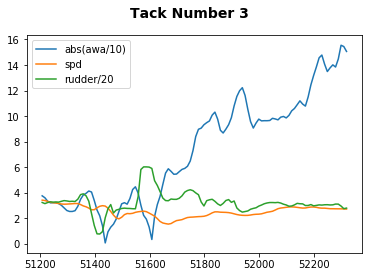

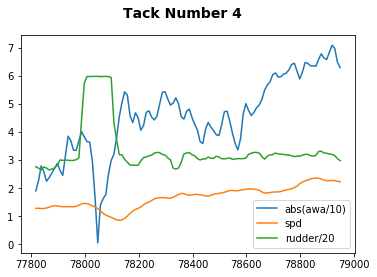

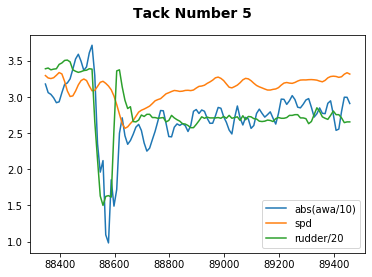

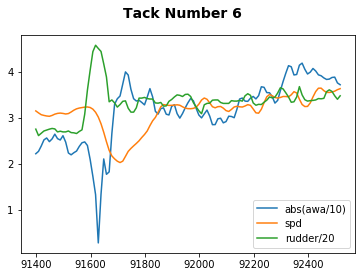

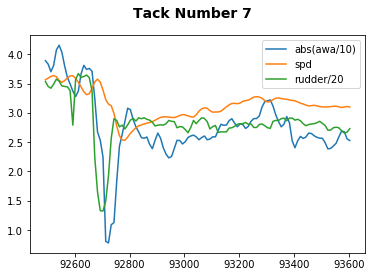

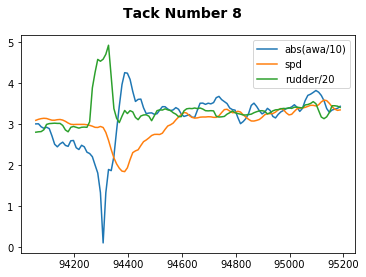

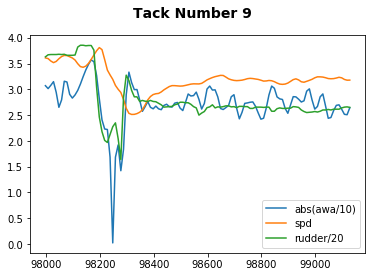

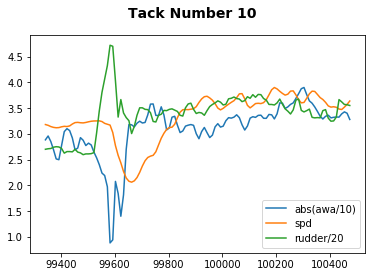

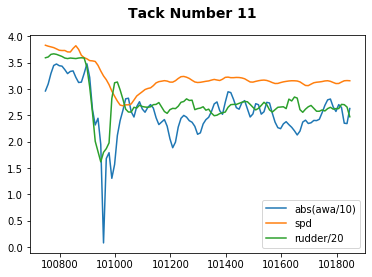

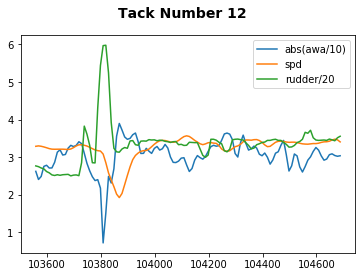

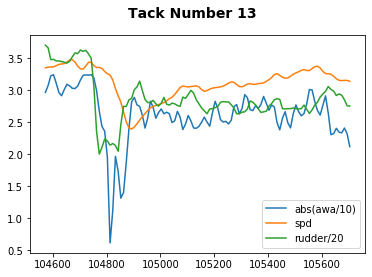

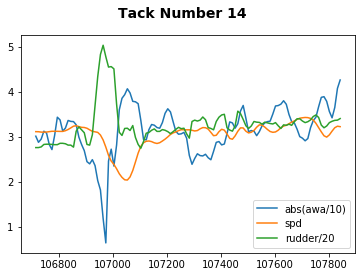

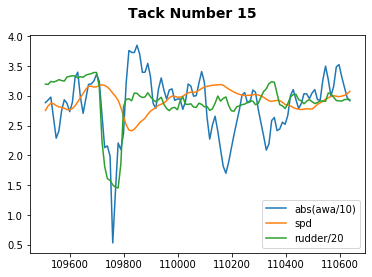

In [113]:
for i in range(len(tacks)):
    a_tack=df.loc[tacks[i]] 
    quick_plot(a_tack.index, 
               (abs(a_tack.awa/10),  a_tack.spd, 3+a_tack.rudder/20), 
               legend='abs(awa/10)  spd rudder/20'.split(),
               title='Tack Number '+str(i), s=slice(None, None, 10))

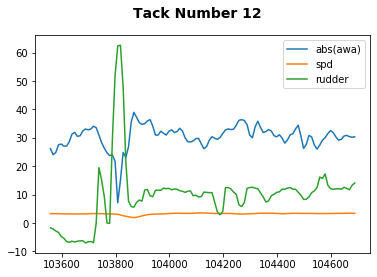

In [115]:
    a_tack=df.loc[tacks[12]] 
    quick_plot(a_tack.index, 
               (abs(a_tack.awa),  a_tack.spd, 3+a_tack.rudder),
               legend='abs(awa)  spd rudder'.split(),
               title='Tack Number '+str(12), s=slice(None, None, 10))

In [26]:
df

,log_seconds,sid,variation,rudder,rhdg,reference,raws,rawa,turn_rate,zeus_latitude,...,awa,aws,twa,tws,twd,spd,hdg,sog,cog,row_times
2676,267.602,0,15.500,8.300,4.200,Magnetic,2.380,164.600,0.445,47.683,...,164.500,2.398,175.506,2.887,195.393,-0.000,4.193,0.000,175.010,2019-11-16 10:13:43.286180689-08:00
2677,267.735,0,15.500,8.300,4.200,Magnetic,2.880,157.500,0.385,47.683,...,163.435,2.466,172.948,2.892,193.140,-0.000,4.227,0.000,178.394,2019-11-16 10:13:43.386178742-08:00
2678,267.825,0,15.500,8.300,4.300,Magnetic,2.880,152.400,0.385,47.683,...,162.391,2.532,170.429,2.896,190.910,-0.000,4.260,0.000,181.974,2019-11-16 10:13:43.486176795-08:00
2679,267.914,0,15.500,8.300,4.300,Apparent,2.880,152.800,0.269,47.683,...,161.375,2.596,167.974,2.901,188.721,-0.000,4.295,0.000,186.003,2019-11-16 10:13:43.586174848-08:00
2680,268.003,0,15.500,8.300,4.300,Magnetic,2.880,152.800,0.385,47.683,...,160.390,2.659,165.609,2.906,186.591,-0.000,4.329,0.000,190.731,2019-11-16 10:13:43.686172901-08:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128861,12886.112,0,15.200,12.200,4.300,Apparent,4.360,143.400,-0.077,47.683,...,144.874,4.314,152.749,3.765,172.277,0.000,4.253,0.000,358.900,2019-11-16 13:44:01.540497527-08:00
128862,12886.207,0,15.200,12.200,4.300,Apparent,4.360,146.200,-0.203,47.683,...,144.558,4.270,152.727,3.768,172.256,0.000,4.249,0.000,358.900,2019-11-16 13:44:01.640495580-08:00
128863,12886.314,0,15.200,12.200,4.200,Apparent,4.360,148.900,-0.077,47.683,...,144.291,4.227,152.707,3.771,172.236,0.000,4.244,0.000,358.900,2019-11-16 13:44:01.740493633-08:00
128864,12886.450,247,15.500,12.200,4.200,Magnetic,3.870,148.000,-0.264,47.683,...,144.069,4.186,152.688,3.773,172.217,0.000,4.240,0.000,358.900,2019-11-16 13:44:01.840491686-08:00


In [28]:
df.columns

Index(['log_seconds', 'sid', 'variation', 'rudder', 'rhdg', 'reference',
       'raws', 'rawa', 'turn_rate', 'zeus_latitude', 'zeus_longitude',
       'cog_reference', 'rsog', 'row_seconds', 'latitude', 'longitude',
       'zg100_sid', 'zg100_heading', 'zg100_variation', 'zg100_reference',
       'zg100_turn_sid', 'zg100_turn_rate', 'date', 'time', 'altitude',
       'gnss_type', 'method', 'integrity', 'number_of_svs', 'hdop', 'pdop',
       'geoidal_separation', 'reference_stations', 'sats_in_view', 'list',
       'source', 'desired_mode', 'actual_mode', 'vdop', 'zg100_pitch',
       'zg100_roll', 'zeus_sid', 'zeus_cog_reference', 'zeus_cog', 'zeus_sog',
       'zeus_source', 'zeus_date', 'zeus_time', 'zeus_variation',
       'zeus_altitude', 'zeus_gnss_type', 'zeus_method', 'zeus_integrity',
       'zeus_number_of_svs', 'zeus_hdop', 'zeus_pdop',
       'zeus_geoidal_separation', 'zeus_desired_mode', 'zeus_actual_mode',
       'zeus_vdop', 'zeus_mode', 'zeus_sats_in_view', 'zeus_list'

In [31]:
df.rudder.describe()

count   126190.000
mean         2.859
std          9.843
min        -44.600
25%         -1.100
50%          1.500
75%          7.200
max         62.400
Name: rudder, dtype: float64

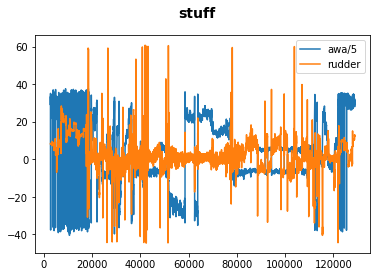

In [68]:
quick_plot(df.index, 
           (df.awa/5, df.rudder), 
           legend='awa/5 rudder'.split(),
           title='stuff', s=slice(None, None, 10))

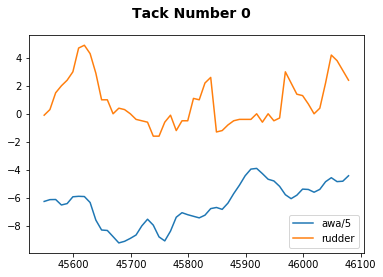

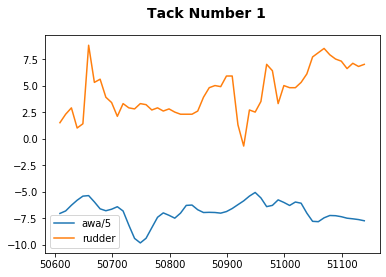

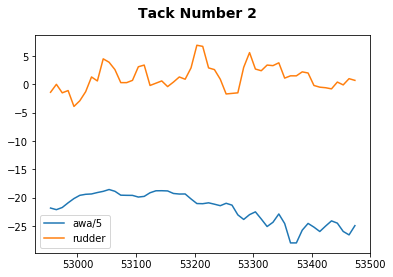

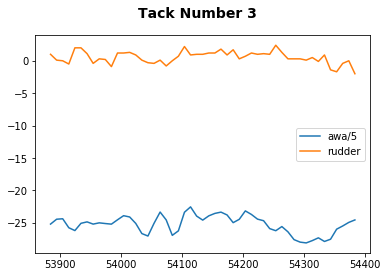

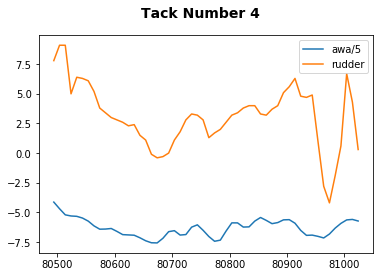

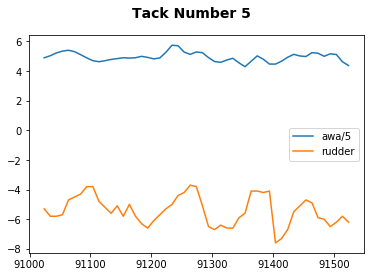

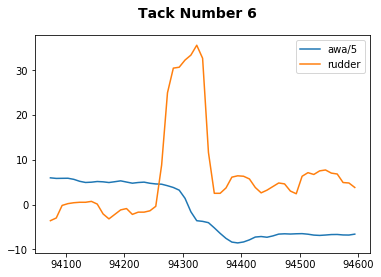

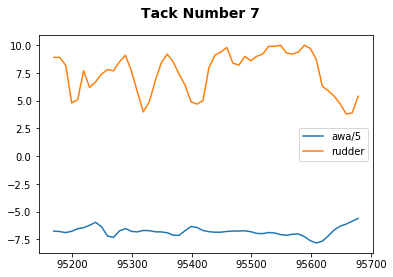

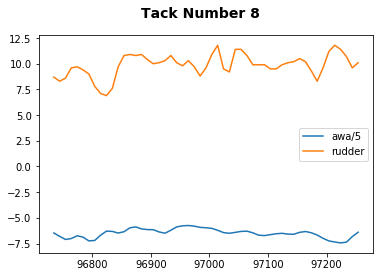

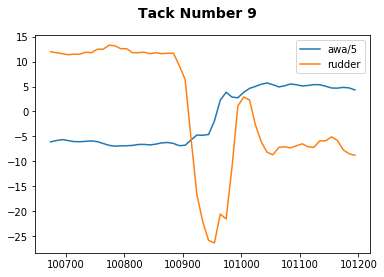

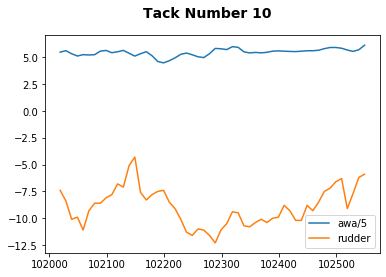

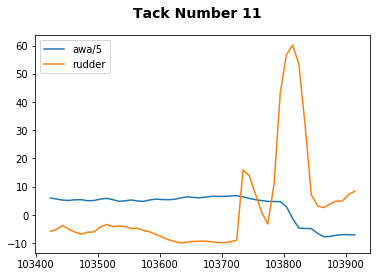

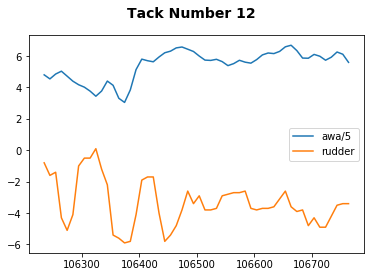

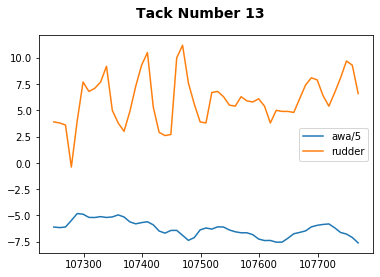

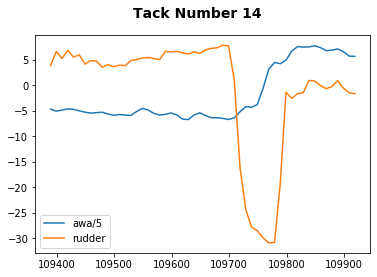

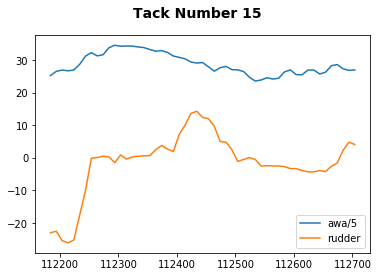

In [65]:
### Let's check the rudder movement looks right on these tacks
for i in range(len(tacks)):
    atack=df[tacks[i]]

    quick_plot(atack.index, 
               (atack.awa/5, atack.rudder), 
               legend='awa/5 rudder'.split(),
               title='Tack Number '+str(i), s=slice(None, None, 10))

In [49]:
type(tacks)
len(tacks)

16

In [25]:
c.plot_chart(df, 3)

error: OpenCV(3.4.2) /opt/concourse/worker/volumes/live/9523d527-1b9e-48e0-7ed0-a36adde286f0/volume/opencv-suite_1535558719691/work/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'


In [122]:
wide_slice = slice(98000, 100000)
wdf = df.loc[wide_slice]

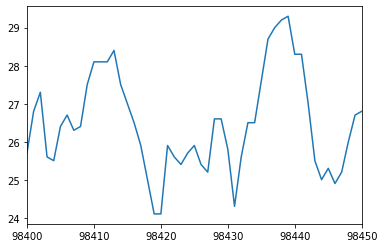

In [132]:
# Let's drill down and look at 5 seconds (50 samples)
narrow_slice = slice(98400, 98450)
ndf = df.loc[narrow_slice]
plt.figure()
ndf.rawa.plot()

In [118]:
ndf.rawa

98400   25.700
98401   26.800
98402   27.300
98403   25.600
98404   25.500
98405   26.400
98406   26.700
98407   26.300
98408   26.400
98409   27.500
98410   28.100
98411   28.100
98412   28.100
98413   28.400
98414   27.500
98415   27.000
98416   26.500
98417   25.900
98418   25.000
98419   24.100
98420   24.100
98421   25.900
98422   25.600
98423   25.400
98424   25.700
98425   25.900
98426   25.400
98427   25.200
98428   26.600
98429   26.600
98430   25.800
98431   24.300
98432   25.600
98433   26.500
98434   26.500
98435   27.600
98436   28.700
98437   29.000
98438   29.200
98439   29.300
98440   28.300
98441   28.300
98442   27.000
98443   25.500
98444   25.000
98445   25.300
98446   24.900
98447   25.200
98448   26.000
98449   26.700
98450   26.800
Name: rawa, dtype: float64

In [119]:
ndf.spd

98400   2.904
98401   2.906
98402   2.908
98403   2.910
98404   2.911
98405   2.912
98406   2.913
98407   2.914
98408   2.915
98409   2.915
98410   2.916
98411   2.916
98412   2.916
98413   2.917
98414   2.917
98415   2.918
98416   2.918
98417   2.919
98418   2.921
98419   2.922
98420   2.924
98421   2.926
98422   2.929
98423   2.932
98424   2.935
98425   2.938
98426   2.942
98427   2.946
98428   2.950
98429   2.954
98430   2.958
98431   2.962
98432   2.966
98433   2.971
98434   2.975
98435   2.979
98436   2.983
98437   2.987
98438   2.990
98439   2.994
98440   2.997
98441   3.001
98442   3.004
98443   3.007
98444   3.010
98445   3.014
98446   3.017
98447   3.020
98448   3.023
98449   3.026
98450   3.030
Name: spd, dtype: float64

In [120]:
ndf.tws

98400   5.345
98401   5.346
98402   5.348
98403   5.350
98404   5.351
98405   5.353
98406   5.355
98407   5.356
98408   5.358
98409   5.360
98410   5.361
98411   5.363
98412   5.364
98413   5.366
98414   5.367
98415   5.368
98416   5.370
98417   5.371
98418   5.372
98419   5.373
98420   5.374
98421   5.375
98422   5.376
98423   5.378
98424   5.379
98425   5.380
98426   5.381
98427   5.382
98428   5.383
98429   5.384
98430   5.385
98431   5.387
98432   5.388
98433   5.389
98434   5.391
98435   5.392
98436   5.393
98437   5.395
98438   5.396
98439   5.397
98440   5.399
98441   5.400
98442   5.401
98443   5.402
98444   5.403
98445   5.404
98446   5.405
98447   5.406
98448   5.407
98449   5.408
98450   5.409
Name: tws, dtype: float64

98000    -47.500
98001    -47.400
98002    -47.400
98003    -47.300
98004    -47.300
           ...  
99996    -47.400
99997    -47.400
99998    -47.400
99999    -47.300
100000   -47.300
Name: rtwa, Length: 2001, dtype: float64

In [127]:
narrow_slice = slice(98600, 98950)
ndf = df.loc[narrow_slice]

In [134]:
ndf.rtwa

98400   37.000
98401   37.000
98402   37.000
98403   37.000
98404   37.000
98405   36.900
98406   36.900
98407   36.700
98408   36.700
98409   36.400
98410   36.400
98411   36.100
98412   36.100
98413   35.800
98414   35.800
98415   35.700
98416   35.700
98417   35.600
98418   35.600
98419   35.500
98420   35.500
98421   35.200
98422   35.200
98423   34.800
98424   34.800
98425   34.500
98426   34.500
98427   34.300
98428   34.300
98429   34.300
98430   34.300
98431   34.200
98432   34.200
98433   34.100
98434   34.100
98435   33.800
98436   33.800
98437   33.500
98438   33.500
98439   33.400
98440   33.400
98441   33.600
98442   33.600
98443   33.900
98444   33.900
98445   34.300
98446   34.300
98447   34.300
98448   34.300
98449   34.200
98450   34.200
Name: rtwa, dtype: float64

In [133]:
ndf.spd.describe()

count   51.000
mean     2.952
std      0.040
min      2.904
25%      2.916
50%      2.938
75%      2.988
max      3.030
Name: spd, dtype: float64